# Evaluation of Retrieval


## Libraries

In [1]:
import json
import os
import warnings
from collections.abc import Callable
from datetime import datetime
from pathlib import Path

import lancedb
import networkx as nx
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from lancedb.rerankers import (
    CohereReranker,
    ColbertReranker,
    CrossEncoderReranker,
    LinearCombinationReranker,
    RRFReranker,
)
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm import tqdm, trange

from src.constants import (
    GROUND_TRUTH_PATH,
    LANCEDB_URI,
    POST_JSON_PATH,
    REPO_PATH,
    get_rag_config,
)
from src.ingestion import create_title_hash

# to ignore FutureWarning from `transformers/tokenization_utils_base.py`
warnings.simplefilter(action="ignore", category=FutureWarning)

/home/alex/repos/rag_nutrition_facts_blog/tvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [29]:
table_name: str = get_rag_config()["knowledge_base"]["table_name"]
ground_truth_file: Path = GROUND_TRUTH_PATH / "eva_ground_truth.csv"
title_groups_file: Path = GROUND_TRUTH_PATH / "eva_title_groups.csv"

# secrets
load_dotenv(REPO_PATH)
cohere_api_key: str = os.getenv("COHERE_API_KEY")


# ignore titles for the evaluation that contain these strings
ignore_titles: list[str] = [
    "Year-in-Review Presentation",
    "Thank You for Your Support",
    "DVD Now Available",
    "Dr. Greger’s New DVD",
    "Dr. Greger’s DVDs",
    "Top 10 NutritionFacts.org Videos",
    "Top 10 Most Popular Videos",
]

# Code

## Load Knowledge Base

In [3]:
db: lancedb.db.DBConnection = lancedb.connect(uri=LANCEDB_URI)
print(f"List of all tables in the LanceDB database: {db.table_names()}")

List of all tables in the LanceDB database: ['fulltext01', 'table01', 'table_simple01', 'table_simple02', 'table_simple03', 'table_simple04', 'table_simple05']


In [4]:
table: lancedb.table.Table = db.open_table(table_name)
print(f"Number of entries in the table '{table_name}': {table.count_rows()}")

Number of entries in the table 'table_simple05': 7023


In [164]:
# Full-text search (aka keyword-based search)
# - https://lancedb.github.io/lancedb/fts/
# table.create_fts_index(["text"], replace=True)

In [165]:
# Vector search Index
# device: str = get_rag_config()["embeddings"]["device"]
# emb_model_metric: str = get_rag_config()["embeddings"]["metric"]
# table.create_index(metric=emb_model_metric, replace=True, accelerator="cuda" if device == "cuda" else None)

## Create ground truth

### Use Blog entry titles as evaluation queries

- try to find titles that are very similar to each other

#### Cosine Similarity Ranges

- **Cosine Similarity = 1.0**: The titles are **exactly identical**.
- **Cosine Similarity > 0.9**: The titles are **highly similar**, often differing only slightly, such as small word variations, synonyms, or rewording that conveys essentially the same idea. This is where titles likely "feel identical" to most readers.
- **Cosine Similarity between 0.7 and 0.9**: The titles are **similar but not identical**. They likely discuss similar topics or concepts but may have different wording or slight shifts in focus. Readers may perceive these as very similar or interchangeable, but subtle differences might exist.
- **Cosine Similarity < 0.7**: The titles are **noticeably different**. They may refer to related topics but convey distinct ideas or focus. Readers would likely view them as different, though related.

Threshold for Perceived Identicalness: For most **human readers**, a cosine similarity score between **0.9 and 1.0** typically corresponds to titles that feel **identical or extremely similar**. This range indicates that the titles share most of their key terms and structure, with only minor variations.


#### Factors Affecting Perceived Similarity:
- **Synonyms and Phrasing**: Different words or phrases with similar meanings (e.g., "guide" vs. "how to").
- **Order of Words**: Titles with the same words but in a different order can have a high similarity score and feel identical to readers.
- **Stopwords**: Removing common words (e.g., "the," "a") in pre-processing can affect the similarity score but might not affect the reader's perception.



### Compute Cosine Similarity between Titles

In [8]:
# get all titles (1281 entries)
file_list = list(POST_JSON_PATH.glob("*.json"))


ignore_list_lower: list[str] = [title.lower() for title in ignore_titles]

titles: list[str] = []
urls: list[str] = []
created: list[str] = []
pbar = tqdm(file_list[:])
for json_file in pbar:
    pbar.set_description(f"{json_file.name[:40]:<40}")

    # load data
    with open(json_file, encoding="utf-8") as f:
        blog_post: dict = json.load(f)
    title: str = blog_post["title"]

    # ignore files without any paragraphs
    if not blog_post["paragraphs"]:
        continue

    # ignore tiles that contain string from `ignore_titles`
    if any(ignored_str in title.lower() for ignored_str in ignore_list_lower):
        continue

    titles.append(blog_post["title"])
    urls.append(blog_post["url"])
    created.append(blog_post["created"])
# <3 seconds

three-brands-of-nutritional-yeast-contai: 100%|██████████| 1281/1281 [00:04<00:00, 259.82it/s]


In [9]:
print(f"Number of titles: {len(titles)}")

Number of titles: 1248


In [ ]:
# Measure similarity between titles
emb_config: dict = get_rag_config()["embeddings"]
emb_model = SentenceTransformer(
    emb_config["model_name"],
    device=emb_config["device"],
    similarity_fn_name=emb_config["metric"],
)
titles_vec: list[list[float]] = emb_model.encode(titles, show_progress_bar=True)
# <10 seconds

In [157]:
titles_sim = pd.DataFrame(emb_model.similarity(titles_vec, titles_vec))

#### plotting similarities

In [ ]:
# Get the similarity scores as pairs
title_pairs = []
similarity_scores = []
for i in trange(titles_sim.shape[0]):
    for j in range(i + 1, titles_sim.shape[1]):
        title_pairs.append((titles_sim.index[i], titles_sim.columns[j]))
        similarity_scores.append(titles_sim.iloc[i, j])

In [ ]:
# Scatter plot
plt.figure(figsize=(15, 4))
plt.scatter(range(len(similarity_scores)), similarity_scores, alpha=0.5, s=1)
plt.title("Pairwise Similarity Scores Between Titles")
plt.xlabel("Title Pairs (Index)")
plt.ylabel("Similarity Score")
plt.show()

In [75]:
# Function to compute average histogram and bin edges


def compute_avg_hist(df: pd.DataFrame, bins=30, range_min=0, range_max=1, cumulative=False):
    # Step 1: Create consistent bin edges for all titles
    bin_edges = np.linspace(range_min, range_max, bins + 1)

    # Step 2: Initialize list to hold the histograms
    hist_data = []

    # Set the diagonal values to NaN or exclude them
    df_no_diag = df.copy()
    np.fill_diagonal(df_no_diag.values, np.nan)

    for i in range(df_no_diag.shape[0]):
        # Exclude the NaN values (self-similarity) from the row
        row_data = df_no_diag.iloc[i, :].dropna()

        # Step 3: Compute the regular histogram for this row
        hist, _ = np.histogram(row_data, bins=bin_edges, density=True)

        if cumulative:
            # Step 4: Compute the cumulative sum, starting from the highest bin to the lowest
            hist = np.cumsum(hist[::-1])[::-1]  # Reverse to high-to-low cumulative sum

        hist_data.append(hist)

    # Step 5: Convert the list of histograms into a NumPy array for easier averaging
    hist_data = np.array(hist_data)

    # Step 6: Compute the average histogram across all rows
    avg_hist = hist_data.mean(axis=0)

    return avg_hist, bin_edges

In [76]:
# Compute the average histogram and bin edges
avg_hist, bin_edges = compute_avg_hist(titles_sim, bins=100, range_min=titles_sim.min().min(), range_max=1)

In [ ]:
# Plot the averaged histogram
plt.figure(figsize=(8, 6))
x_bar = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate the bin centers
plt.bar(x=x_bar, height=avg_hist, width=(bin_edges[1] - bin_edges[0]), edgecolor="black", alpha=0.7)
plt.title("Averaged Histogram of Similarity Scores for All Titles")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [78]:
# Compute the average Cumulative  histogram and bin edges
avg_hist, bin_edges = compute_avg_hist(
    titles_sim, bins=100, range_min=titles_sim.min().min(), range_max=1, cumulative=True
)

In [ ]:
# Plot the averaged histogram
plt.figure(figsize=(8, 6))
x_bar = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate the bin centers
height = avg_hist  # / avg_hist[0]
plt.bar(x=x_bar, height=height, width=(bin_edges[1] - bin_edges[0]), edgecolor="black", alpha=0.7)
plt.title("Averaged Cumulative Histogram of Similarity Scores (High to Low)")
plt.xlabel("Similarity")
plt.ylabel("Cumulative Frequency (Density)")
plt.yscale("log")
# horizaontl line at one
plt.axhline(y=1, color="r", linestyle="-")
plt.show()

### Find groups of titles with high Cosine Similarity

In [55]:
def group_titles_by_similarity(df: pd.DataFrame, threshold: float = 0.9) -> list[list[int]]:
    """
    Groups titles based on cosine similarity scores in the DataFrame `df`.
    Titles are grouped together if their similarity score is greater than `threshold`.

    Parameters:
    df (pd.DataFrame): DataFrame containing pairwise similarity scores, where rows and columns represent titles.
    threshold (float): The similarity score threshold for grouping titles (default is 0.9).

    Returns:
    List of lists, where each sublist contains indices of grouped titles.
    """
    # Create a graph
    G = nx.Graph()

    # Add nodes (each title is a node)
    titles = df.index
    G.add_nodes_from(titles)

    # Add edges between nodes if the similarity score is above the threshold
    for i in trange(df.shape[0]):
        for j in range(i + 1, df.shape[1]):
            if df.iloc[i, j] > threshold:
                G.add_edge(titles[i], titles[j])

    # Find connected components (groups of titles) and filter out groups with only one title
    groups = [group for component in nx.connected_components(G) if len(group := list(component)) > 1]

    return groups

In [ ]:
groups: list[list[int]] = group_titles_by_similarity(titles_sim, threshold=0.8)
# <30 seconds

In [ ]:
# Output the grouped titles
print(f"Number of groups: {len(groups)}")
for g, group in enumerate(groups):
    print(f"{g}. Group:", group)
    dates = [datetime.fromisoformat(created[i]) for i in group]
    # order by date
    order = np.argsort(dates)
    group = [group[i] for i in order]

    i_ref: int = group[-1]  # take most recent title
    for i_title in group:
        print(f"\t({titles_sim.iloc[i_ref, i_title]:.2f}) ({created[i_title][:10]})  {titles[i_title]}")

In [162]:
# save groups
out = {}
for g, group in enumerate(groups):
    # print(f"{g}. Group:", group)
    dates = [datetime.fromisoformat(created[i]) for i in group]
    # order by date
    order = np.argsort(dates)
    group = [group[i] for i in order]
    out[g] = [[create_title_hash({"title": titles[i_title], "url": urls[i_title]}) for i_title in group]]

pd.DataFrame().from_dict(out, orient="index").to_csv(title_groups_file, index=False)

#### test hash filter

In [163]:
# compare with expected
groups_from_file = pd.read_csv(title_groups_file)
for g, group in enumerate(groups):
    expected = {titles[i_title] for i_title in group}
    hash_filter: str = groups_from_file.iloc[g, 0].replace("[", "").replace("]", "")
    resp = set(table.search().where(f"hash_title in ({hash_filter})").limit(100).to_pandas()["title"].to_list())
    if resp != expected:
        print(f"Expected: {expected}")
        print(f"Response: {resp}")
        print(hash_filter)
        group_urls = [urls[i_title] for i_title in group]
        print(group_urls)

### create ground truth

- csv: title, hash_title, allowed_hashes


In [31]:
def str_to_list(s: str) -> list[str]:
    return s.replace("[", "").replace("]", "").replace("'", "").split(", ")


title_groups: list[list[str]] = pd.read_csv(title_groups_file).iloc[:, 0].apply(str_to_list).to_list()

ground_truth: list[dict] = []
for title, url in tqdm(zip(titles, urls), total=len(titles)):
    hash_title: str = create_title_hash({"title": title, "url": url})

    # get has of text chunk that has the highest similarity to `title`
    best_doc_dict: dict[str, float | str] = (
        table.search()
        .where(f"hash_title == '{hash_title}'")
        .limit(100)
        .to_pandas()[["sim_doc_title", "hash_doc"]]
        .sort_values(by="sim_doc_title", ascending=False)
        .iloc[0]
        .to_dict()
    )

    # check if hash appears in any group from `title_groups` and if yes, add group hashes to `allowed_hases`
    allowed_hashes: set[str] = {hash_title}
    for group in title_groups:
        if hash_title in group:
            allowed_hashes.update(group)

    ground_truth.append(
        {
            "title": title.strip(),
            "hash_title": hash_title,
            "allowed_hashes": list(allowed_hashes),
            "best_doc_hash": best_doc_dict["hash_doc"],
            "best_doc_sim": best_doc_dict["sim_doc_title"],
        }
    )

# save to file
pd.DataFrame(ground_truth).to_csv(ground_truth_file, index=False)

100%|██████████| 1248/1248 [00:06<00:00, 190.35it/s]


In [48]:
sim_limit = 0.6
best_doc_sim = pd.read_csv(ground_truth_file)["best_doc_sim"]
# compute fraction where best_doc_sim < 0.5
n_below: int = sum(best_doc_sim < sim_limit)
frac = n_below / len(best_doc_sim)
print(f"Fraction of titles with best_doc_sim < {sim_limit}: {frac:.0%} ({n_below} out of {len(best_doc_sim)})")

Fraction of titles with best_doc_sim < 0.6: 33% (406 out of 1248)


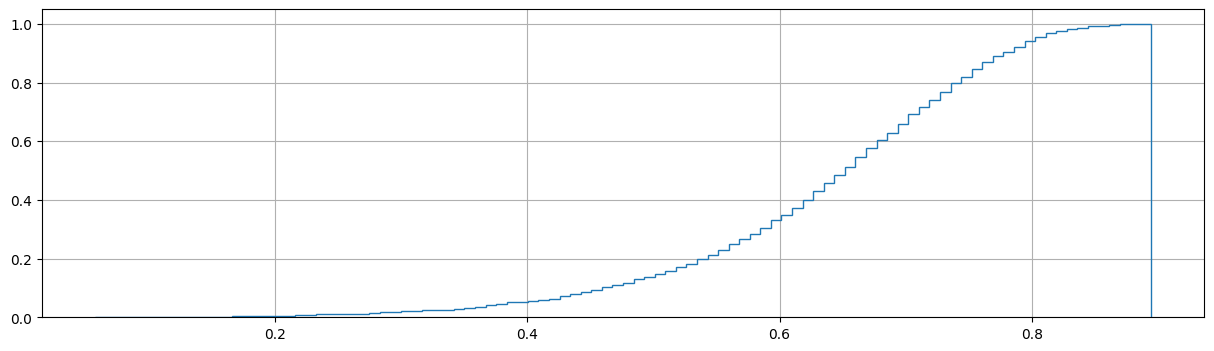

In [47]:
# plot "best_doc_sim" as cumulative histogram
plt.figure(figsize=(15, 4))
plt.hist(best_doc_sim, bins=100, cumulative=True, density=True, histtype="step")
plt.grid(True)
plt.show()

## Retriever Evaluation

- titles are user queries
- a query should return a text chunk from the same blog post or from another blog post with similar cosine similarity in respect to the title

In [5]:
def measure_relevance(
    ground_truth: list[dict],
    search_func: Callable[[], pd.DataFrame],
    **kwargs,
) -> list[list[bool]]:
    relevance_total: list[list[bool]] = []
    for entry in tqdm(ground_truth):
        allowed_hashes: list[str] = entry["allowed_hashes"]

        title: str = entry["title"]
        query: str = title.lower().replace(":", " ").replace("\u00a0", " ").strip()
        resp: pd.DataFrame = search_func(query=query, **kwargs)
        retrieved_hashes: list[str] = resp["hash_title"].to_list()
        relevance: list[bool] = [h in allowed_hashes for h in retrieved_hashes]
        relevance_total.append(relevance)

    return relevance_total


def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)


def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] is True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [6]:
ground_truth = pd.read_csv(ground_truth_file).to_dict(orient="records")

#### Basic search methods: keyword (fts), vector, hybrid

- hybrid uses "Reciprocal Rank Fusion Reranker"

```python
100%|██████████| 1248/1248 [00:10<00:00, 123.77it/s]
fts - 0:00:10.086127 - 0.819 - 0.948
100%|██████████| 1248/1248 [00:40<00:00, 30.87it/s] 
vector - 0:00:40.431775 - 0.809 - 1.055
100%|██████████| 1248/1248 [00:55<00:00, 22.34it/s]
hybrid - 0:00:55.859763 - 0.841 - 1.139
```

In [ ]:
def basic_search(query: str, query_type: str, top_k: int = 5) -> pd.DataFrame:
    return table.search(query=query, query_type=query_type).limit(top_k).to_pandas()


res_basic_search: dict[str, list[list[bool]]] = {}
for query_type in ["fts", "vector", "hybrid"]:
    t_start = datetime.now()
    relevance: list[list[bool]] = measure_relevance(ground_truth, search_func=basic_search, query_type=query_type)
    t_dur = datetime.now() - t_start
    res_basic_search[query_type] = relevance
    print(f"{query_type} - {t_dur} - {hit_rate(relevance):.3f} - {mrr(relevance):.3f}")

#### Hybrid search

##### `LinearCombinationReranker`
- https://lancedb.github.io/lancedb/reranking/linear_combination/

In [12]:
def hybrid_search_lc(query: str, top_k: int = 5, weight=0.7) -> pd.DataFrame:
    reranker_lc = LinearCombinationReranker(weight=weight)
    return table.search(query=query, query_type="hybrid").rerank(reranker=reranker_lc).limit(top_k).to_pandas()

In [ ]:
relevance_h07: list[list[bool]] = measure_relevance(ground_truth, search_func=hybrid_search_lc, weight=0.7)
hit_rate(relevance_h07), mrr(relevance_h07)

In [ ]:
relevance_h03: list[list[bool]] = measure_relevance(ground_truth, search_func=hybrid_search_lc, weight=0.3)
hit_rate(relevance_h03), mrr(relevance_h03)

#### Reciprocal Rank Fusion Reranker
https://lancedb.github.io/lancedb/reranking/rrf/

In [15]:
def hybrid_search_rrf(query: str, top_k: int = 5) -> pd.DataFrame:
    reranker = RRFReranker()
    return table.search(query=query, query_type="hybrid").rerank(reranker=reranker).limit(top_k).to_pandas()

In [ ]:
relevance_rrf: list[list[bool]] = measure_relevance(ground_truth, search_func=hybrid_search_rrf)
hit_rate(relevance_rrf), mrr(relevance_rrf)

#### Summary

```test
               hit_rate       mrr
rrf            0.843750  1.159802
hybrid         0.841346  1.138715
lc_weight_0.7  0.841346  1.138715
lc_weight_0.3  0.841346  1.138715
fts            0.818910  0.947983
vector         0.809295  1.054688
```

In [ ]:
res_all = {}
res_all.update(res_basic_search)
res_all["rrf"] = relevance_rrf
res_all["lc_weight_0.7"] = relevance_h07
res_all["lc_weight_0.3"] = relevance_h03
scores_all = {key: {"hit_rate": hit_rate(res_all[key]), "mrr": mrr(res_all[key])} for key in res_all}
pd.DataFrame.from_dict(scores_all, orient="index").sort_values(by="hit_rate", ascending=False)

#### Reranker: Coher (rate limit too low)
- https://lancedb.github.io/lancedb/reranking/cohere/
- only trial api key:  10 API calls / minute

In [18]:
def search_rr_cohere(query: str, query_type: str, top_k: int = 5) -> pd.DataFrame:
    reranker = CohereReranker(api_key=cohere_api_key)
    return table.search(query=query, query_type=query_type).rerank(reranker=reranker).limit(top_k).to_pandas()

In [19]:
rr_cohere_res: dict[str, list[list[bool]]] = {}

In [ ]:
# for q_type in ["fts"]:  # , "vector", "hybrid"]:
#     rr_cohere_res[q_type] = measure_relevance(ground_truth, search_func=search_rr_cohere, query_type=q_type)
#     print(q_type, hit_rate(rr_cohere_res[q_type]), mrr(rr_cohere_res[q_type]))

#### Reranker: Cross Encoder (very slow!)

- https://lancedb.github.io/lancedb/reranking/cross_encoder/
- Evaluation  very slow! >1h for fts

In [16]:
def search_rr_cross(query: str, query_type: str, top_k: int = 5) -> pd.DataFrame:
    reranker = CrossEncoderReranker(device="cpu")
    return table.search(query=query, query_type=query_type).limit(10).rerank(reranker=reranker).limit(top_k).to_pandas()

In [ ]:
rr_cross_res: dict[str, list[list[bool]]] = {}
for q_type in ["hybrid"]:  # "fts", "vector", ]:
    rr_cross_res[q_type] = measure_relevance(ground_truth, search_func=search_rr_cross, query_type=q_type)
    print(q_type, hit_rate(rr_cross_res[q_type]), mrr(rr_cross_res[q_type]))

#### Reranker: ColBERT  (slow)
- https://lancedb.github.io/lancedb/reranking/colbert/
- Evaluation  slow! >30min for fts

In [14]:
def search_rr_colbert(query: str, query_type: str, top_k: int = 5) -> pd.DataFrame:
    reranker = ColbertReranker()  # device="cpu")
    return table.search(query=query, query_type=query_type).limit(10).rerank(reranker=reranker).limit(top_k).to_pandas()

In [ ]:
rr_colbert_res: dict[str, list[list[bool]]] = {}
for q_type in ["hybrid"]:  # "fts", "vector", ]:
    rr_colbert_res[q_type] = measure_relevance(ground_truth, search_func=search_rr_colbert, query_type=q_type)
    print(q_type, hit_rate(rr_colbert_res[q_type]), mrr(rr_colbert_res[q_type]))